In [38]:
if False:
    import sys
    !{sys.executable} -m pip install requests
    !{sys.executable} -m pip install geopandas
    !{sys.executable} -m pip install matplotlib
    !{sys.executable} -m pip install networkx
    !{sys.executable} -m pip install folium

In [39]:
import os
import sys
import json
import glob
import folium
import requests
import datetime
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [40]:
apikey = 'JydUr1HO7ejqBhw0YP19W3b1GonFwmzr'

In [41]:
# Define coordinate reference system (CRS) codes
# WGS 84
WGS84 = {'init':'epsg:4326'}
# British National Grid
BNG = {'init':'epsg:27700'}

In [42]:
wfs_endpoint = ('https://api.os.uk/features/v1/wfs')
filter_coords = "50.989012935589244,-0.9178717664495366 50.9645569801383,-0.9223751250371492 50.95338802238439,-0.8959178933630483 50.95391993839533,-0.8618612440900222 50.967747617825694,-0.8452551093233751 50.9829887509967,-0.8483511683495237 50.99468204223871,-0.8787488387748397 50.989012935589244,-0.9178717664495366"

params = {
    "key":apikey,
    "service":"WFS",
    "request":"GetFeature",
    "version":"2.0.0",
    "typeNames":"Highways_RoadLink",
    "outputFormat":"GEOJSON",
    "srsName":"urn:ogc:def:crs:EPSG::4326",
    "count":100,
    "startIndex":0,
    "filter":("<ogc:Filter><ogc:Intersects><ogc:PropertyName>SHAPE</ogc:PropertyName><gml:Polygon srsName='urn:ogc:def:crs:EPSG::4326'><gml:outerBoundaryIs><gml:LinearRing><gml:coordinates>" + filter_coords + "</gml:coordinates></gml:LinearRing></gml:outerBoundaryIs></gml:Polygon></ogc:Intersects></ogc:Filter>")
    }

q = requests.Request('GET', wfs_endpoint, params=params).prepare().url



In [43]:
num_results = 100

data = {
    'type': 'FeatureCollection',
    'features': []
}

i = 1
while num_results >= params['count'] and i < 5:
    
    try:
        r = requests.get(wfs_endpoint, params=params)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:  
        print(e)

    # Decode JSON payload returned by request    
    next_page = r.json()
    
    data['features'] += next_page['features']
    
    num_results = len(next_page['features'])
    params['startIndex'] += params['count']
    print("Fetching Page " + str(i))
    i+= 1

Fetching Page 1
Fetching Page 2
Fetching Page 3


In [61]:
# Locally stored network - not needed now that the Features API calls are working
# with open('./samples/sample-roads.json') as sample:
#     data = json.load(sample)

In [46]:
def levelUpLinestring(feature):
    feature['geometry']['coordinates'] = feature['geometry']['coordinates'][0] 
    return feature

In [47]:
features = list(map(levelUpLinestring, data['features']))
gdf = gpd.GeoDataFrame.from_features(data['features'])

In [48]:
gdf.head()

,geometry,OBJECTID,ID,Identifier,InspireIDNamespace,InspireIDLocalID,Fictitious,RoadClassification,RouteHierarchy,FormOfWay,...,ElevationGainInOppDir,FormsPartOf,StartNode,EndNode,RelatedRoadArea,BeginLifespanVersion,ValidForm,ReasonForChange,AlternateIdentifierScheme,SHAPE_Length
0,"LINESTRING (-0.88476 50.96260, -0.88466 50.962...",18680,osgb4000000023260975,http://data.os.uk/id/4000000023260975,http://data.os.uk/,4000000023260975,false,B Road,B Road,Single Carriageway,...,0,"Road#osgb4000000023510372,Street#usrn7200276,S...",osgb4000000023129665,osgb4000000023129675,"osgb1000002077193653,osgb1000002077193721,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),852.691734
1,"LINESTRING (-0.88525 50.97960, -0.88518 50.979...",18681,osgb4000000023260985,http://data.os.uk/id/4000000023260985,http://data.os.uk/,4000000023260985,false,Classified Unnumbered,Minor Road,Single Carriageway,...,10.5,"Street#usrn7203088,Street#usrn83780084",osgb4000000023129734,osgb4000000023129714,"osgb1000002077199151,osgb1000002077199247,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),436.667258
2,"LINESTRING (-0.88169 50.97656, -0.88095 50.976...",18791,osgb4000000023269845,http://data.os.uk/id/4000000023269845,http://data.os.uk/,4000000023269845,false,Classified Unnumbered,Minor Road,Single Carriageway,...,0.9,"Street#usrn7200430,Street#usrn83780084",osgb4000000023129714,osgb4000000023129724,"osgb1000002077199128,osgb1000002077199237,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),298.778284
3,"LINESTRING (-0.88333 50.96648, -0.88280 50.966...",42522,osgb4000000023323643,http://data.os.uk/id/4000000023323643,http://data.os.uk/,4000000023323643,false,Unclassified,Local Road,Single Carriageway,...,0,"Road#osgb4000000023494521,Street#usrn7201080",osgb4000000023129668,osgb4000000023129669,"osgb1000002077198306,osgb1000002077198311",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),78.863642
4,"LINESTRING (-0.88638 50.98856, -0.88643 50.988...",180216,osgb4000000023262310,http://data.os.uk/id/4000000023262310,http://data.os.uk/,4000000023262310,false,Classified Unnumbered,Minor Road,Single Carriageway,...,15.8,"Street#usrn7200432,Street#usrn83780084",osgb4000000023129745,osgb4000000023147282,"osgb1000002077199992,osgb1000002077200050,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),686.167994


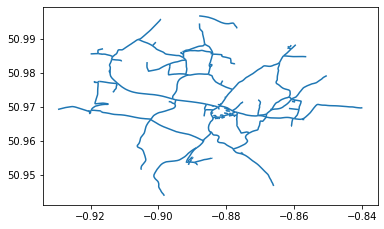

In [49]:
gdf.plot()

In [50]:
gdf['Length'] = pd.to_numeric(gdf['Length'])
gdf['ElevationGainInDir'] = pd.to_numeric(gdf['ElevationGainInDir'])
gdf['ElevationGainInOppDir'] = pd.to_numeric(gdf['ElevationGainInOppDir'])

## Calculate weight

We will create a simple weighting algorithm, which we will assign as the path "weight" of a link in our graph. This weighting algorithm takes advantage of the fact that the OS Features API includes rich attribution with each geographic feature. 

For our use case - finding direct and low-traffic cycling routes - we will emphasize certain factors. Specifically, our weighting algorithm will integrate dimensions including: 

| Dimension | Affect on weight |
| --- | --- |
| `RouteHierarchy` | Smaller roads have lower weight |
| `FormOfWay` | Smaller roads have lower weight |
| `Length` | Longer roads have greater weight  |
| `ElevationGainInDir` | Greater values have greater weight |
| `ElevationGainInOppDir` | Greater values have greater weight |

In [51]:
def cyclingWeight(row):
    weight = 0
    weight += row['Length'] / 1000
    weight += row['ElevationGainInDir'] / 10
    weight += row['ElevationGainInOppDir'] / 10
    
    return weight
    

In [52]:
gdf['weight'] = gdf.apply(cyclingWeight, axis=1)

In [53]:
G = nx.from_pandas_edgelist(gdf, 'StartNode', 'EndNode', ['weight'])

In [54]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 198
Number of edges: 223
Average degree:   2.2525


In [55]:
gdf.head()

,geometry,OBJECTID,ID,Identifier,InspireIDNamespace,InspireIDLocalID,Fictitious,RoadClassification,RouteHierarchy,FormOfWay,...,FormsPartOf,StartNode,EndNode,RelatedRoadArea,BeginLifespanVersion,ValidForm,ReasonForChange,AlternateIdentifierScheme,SHAPE_Length,weight
0,"LINESTRING (-0.88476 50.96260, -0.88466 50.962...",18680,osgb4000000023260975,http://data.os.uk/id/4000000023260975,http://data.os.uk/,4000000023260975,false,B Road,B Road,Single Carriageway,...,"Road#osgb4000000023510372,Street#usrn7200276,S...",osgb4000000023129665,osgb4000000023129675,"osgb1000002077193653,osgb1000002077193721,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),852.691734,10.01269
1,"LINESTRING (-0.88525 50.97960, -0.88518 50.979...",18681,osgb4000000023260985,http://data.os.uk/id/4000000023260985,http://data.os.uk/,4000000023260985,false,Classified Unnumbered,Minor Road,Single Carriageway,...,"Street#usrn7203088,Street#usrn83780084",osgb4000000023129734,osgb4000000023129714,"osgb1000002077199151,osgb1000002077199247,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),436.667258,2.26666
2,"LINESTRING (-0.88169 50.97656, -0.88095 50.976...",18791,osgb4000000023269845,http://data.os.uk/id/4000000023269845,http://data.os.uk/,4000000023269845,false,Classified Unnumbered,Minor Road,Single Carriageway,...,"Street#usrn7200430,Street#usrn83780084",osgb4000000023129714,osgb4000000023129724,"osgb1000002077199128,osgb1000002077199237,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),298.778284,0.39877
3,"LINESTRING (-0.88333 50.96648, -0.88280 50.966...",42522,osgb4000000023323643,http://data.os.uk/id/4000000023323643,http://data.os.uk/,4000000023323643,false,Unclassified,Local Road,Single Carriageway,...,"Road#osgb4000000023494521,Street#usrn7201080",osgb4000000023129668,osgb4000000023129669,"osgb1000002077198306,osgb1000002077198311",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),78.863642,0.30886
4,"LINESTRING (-0.88638 50.98856, -0.88643 50.988...",180216,osgb4000000023262310,http://data.os.uk/id/4000000023262310,http://data.os.uk/,4000000023262310,false,Classified Unnumbered,Minor Road,Single Carriageway,...,"Street#usrn7200432,Street#usrn83780084",osgb4000000023129745,osgb4000000023147282,"osgb1000002077199992,osgb1000002077200050,osgb...",4/15/2017,null,Modified Geometry And Attributes,NSG Elementary Street Unit ID (ESU ID),686.167994,2.65616


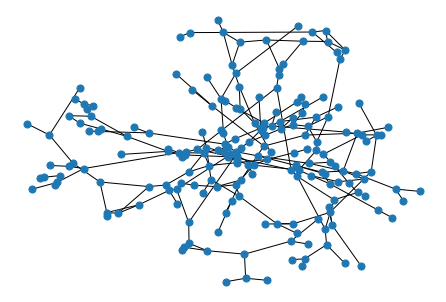

In [56]:
nx.draw(G, node_size=50)#, edge_color=list(gdf.weight), edge_cmap=plt.get_cmap('Greens_r'))

In [57]:
dijkstraPathNodes = nx.dijkstra_path(G, list(G.nodes())[10], list(G.nodes())[50], 'weight')
shortestPathNodes = nx.shortest_path(G, list(G.nodes())[10], list(G.nodes())[50], 'weight')

In [58]:
shortestPathMask = gdf['StartNode'].isin(shortestPathNodes) & gdf['EndNode'].isin(shortestPathNodes)
dijkstraPathMask = gdf['StartNode'].isin(dijkstraPathNodes) & gdf['EndNode'].isin(dijkstraPathNodes)

In [59]:
# OS Maps API (WMTS) endpoint path: /OSMapsAPI/wmts/v1?
wmts_endpoint = 'https://api.os.uk/maps/raster/v1/wmts?'

# Define WMTS parameters 
service = 'wmts'
request = 'GetTile'
version = '2.0.0'
style = 'default'
# Light style base map in Web Mercator projection (EPSG:3857)
layer = 'Light_3857'
tileMatrixSet = 'EPSG:3857'
tileMatrix = 'EPSG:3857:{z}'
tileRow = '{y}'
tileCol ='{x}'

# Represent WMTS parameters in a dictionary
params_wmts = {'key':apikey, 
              'service':service, 
              'request':request,
              'version':'2.0.0',
              'style':style,
              'layer':layer,
              'tileMatrixSet':tileMatrixSet,
              'tileMatrix':tileMatrix,
              'tileRow':tileRow,
              'tileCol':tileCol}

# Construct WMTS API path
wmts_path = wmts_endpoint + \
           ('key={key}&'
            'service={service}&'
            'request={request}&'
            'version={version}&'
            'style={style}&'
            'layer={layer}&'
            'tileMatrixSet={tileMatrixSet}&'
            'tileMatrix={tileMatrix}&'
            'tileRow={tileRow}&'
            'tileCol={tileCol}').format(**params_wmts)

print('=> Constructed OS Maps API URL: {}'.format(wmts_path))

=> Constructed OS Maps API URL: https://api.os.uk/maps/raster/v1/wmts?key=JydUr1HO7ejqBhw0YP19W3b1GonFwmzr&service=wmts&request=GetTile&version=2.0.0&style=default&layer=Light_3857&tileMatrixSet=EPSG:3857&tileMatrix=EPSG:3857:{z}&tileRow={y}&tileCol={x}


In [60]:
# Obtain current date-time

# Create a new Folium map
# Ordnance Survey basemap using the OS Data Hub WMTS centred on the boundary centroid location
# Zoom levels 7 - 16 correspond to the open data zoom scales only
m = folium.Map(location=[50.916438, -1.397284],
               min_zoom=7, 
               max_zoom=18,
               tiles=wmts_path,
               attr='Contains OS data © Crown copyright and database right 2020')

# Define feature style function
def style(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#ff1f5b',
            'color': '#ff1f5b',
            'weight': 1,
            'fillOpacity':.3}

# Define feature highlight function
def highlight(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be highlighted on-hover
    """
    return {'weight':3, 
            'color':'#bf1747'}

def routeStyle(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': '#00CD6C',
            'color': '#00CD6C',
            'weight': 3,
            'fillOpacity':.3}

def dijkstraStyle(feature):
    """
    Defines how GeoJSON features in a Leaflet overlay will be styled
    """
    return {'fillColor': 'blue',
            'color': 'blue',
            'weight': 3,
            'fillOpacity':.3}

# Define feature layer using boundary GeoJSON returned by WFS
overlay = folium.GeoJson(data, 
                         #name=gdf_boundary['lad19nm'],
                         style_function=style,
                         highlight_function=highlight,
                        tooltip=folium.features.GeoJsonTooltip(
                            fields=['ID','RoadClassification',
                               'RouteHierarchy', 'FormOfWay', 
                               'RoadClassificationNumber', 'RoadName1', 'OperationalState',
                               'Directionality', 'Length', 
                               'ElevationGainInDir', 'ElevationGainInOppDir', 
                               'StartNode', 'EndNode']
                            )
                        )

shortestRoute = folium.GeoJson(gdf[shortestPathMask].to_json(),
                        style_function=routeStyle,
                        highlight_function=highlight,
                        tooltip=folium.features.GeoJsonTooltip(
                            fields=['ID','RoadClassification',
                               'RouteHierarchy', 'FormOfWay', 
                               'RoadClassificationNumber', 'RoadName1', 'OperationalState',
                               'Directionality', 'Length', 
                               'ElevationGainInDir', 'ElevationGainInOppDir', 
                               'StartNode', 'EndNode']
                            )
                      )


dijkstraRoute = folium.GeoJson(gdf[dijkstraPathMask].to_json(),
                        style_function=dijkstraStyle,
                        highlight_function=highlight,
                        tooltip=folium.features.GeoJsonTooltip(
                            fields=['ID','RoadClassification',
                               'RouteHierarchy', 'FormOfWay', 
                               'RoadClassificationNumber', 'RoadName1', 'OperationalState',
                               'Directionality', 'Length', 
                               'ElevationGainInDir', 'ElevationGainInOppDir', 
                               'StartNode', 'EndNode']
                            )
                      )

# Add feature layer to map
overlay.add_to(m)
shortestRoute.add_to(m)
dijkstraRoute.add_to(m)

# Fit bounds to the area of analysis
m.fit_bounds([[gdf.total_bounds[1], gdf.total_bounds[0]], [gdf.total_bounds[3], gdf.total_bounds[2]]])

# Return map object
m